In [1]:
from utils import *

import matplotlib.pyplot as plt
import seaborn as sb
from utils import *
import numpy as np

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

### Client count.
In both the training and test datasets, each account with a loan only has 1 or 2 clients. Therefore, for this analysis, it will be counted as binary

In [2]:
print("Encountered client count values in the training dataset:\n" + str(train_df["client_count_mean"].value_counts().index.to_list()) + " \nTesting dataset:\n" + str(test_df["client_count_mean"].value_counts().index.to_list()))

Encountered client count values in the training dataset:
[1, 2] 
Testing dataset:
[1, 2]


### Remove categoric data

In [3]:
train_df_analysis = train_df

# # Removing ids
# del train_df_analysis["loan_id"]
# Removing categoric variables
del train_df_analysis["status"]
#del train_df_analysis["sex"]
del train_df_analysis["num_times_under_zero"]

del train_df_analysis["issuance_frequency_per_month"]
# Also counts as categoric data for this analysis
del train_df_analysis["client_count_mean"]


### Plot Value distributions

### Histogram

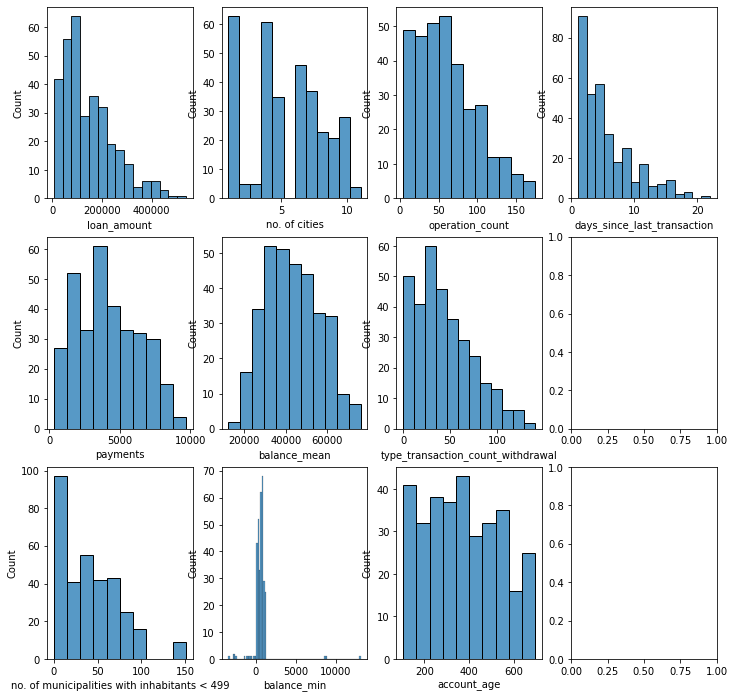

In [4]:
nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12, 12])
i = 0
for col_name in train_df_analysis:
    if(col_name != "loan_id"):
        axs = sb.histplot(data=train_df_analysis, x=train_df_analysis[col_name], ax=ax[(int(i)%nrows), (int(i)//nrows)])
        i = i + 1

plt.show()

Variables that may have outliers from looking at the histogram (by descending order of likelihood): 
balance_min, 
no. of municipalities with inhabitants < 499, 
days_since_last_transaction

### Boxplot

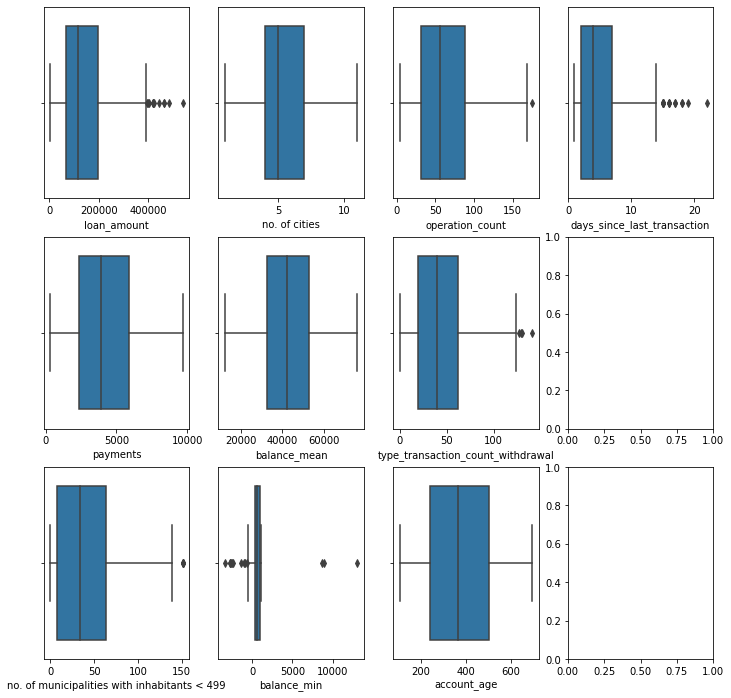

In [5]:
nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12, 12])
i = 0
for col_name in train_df_analysis:
    if(col_name != "loan_id"):
        axs = sb.boxplot(data=train_df_analysis, x=train_df_analysis[col_name], ax=ax[(int(i)%nrows), (int(i)//nrows)])
        i = i + 1

plt.show()

Variables that may have outliers from looking at the boxplot (by descending order of likelihood): 
loan_amount, 
operation_count, 
days_since_last_transaction, 
no. of municipalities with inhabitants < 499, 
balance_min

### Using coeficients of variation to compare each variable's deviation.

In [6]:
coeficients_of_variation = {}
standard_deviations = {}
means = {}
# Calculate coeficients of variation (standard variation / mean * 100[%])
for col_name in train_df_analysis:
    coeficients_of_variation[col_name] = np.std(train_df_analysis[col_name])
    standard_deviations[col_name] = coeficients_of_variation[col_name]
    means[col_name] = np.average(train_df_analysis[col_name])
    coeficients_of_variation[col_name] /= means[col_name] / 100
coeficients_of_variation

{'loan_id': 10.74771714624751,
 'loan_amount': 72.31969874170875,
 'payments': 52.765836983908116,
 'no. of municipalities with inhabitants < 499': 85.97373822506141,
 'no. of cities': 53.96585980480534,
 'balance_mean': 30.628986180690962,
 'balance_min': 175.24641537998872,
 'operation_count': 63.263362313946985,
 'type_transaction_count_withdrawal': 70.05735095406341,
 'account_age': 43.695686135425866,
 'days_since_last_transaction': 77.38193866770357}

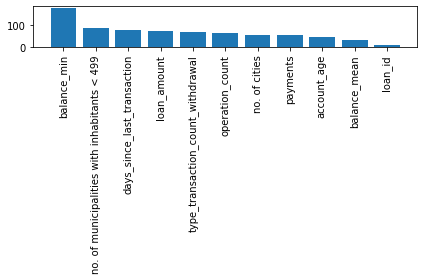

In [7]:
# Barplot of coeficients of variation
coeficients_of_variation_sorted = dict(sorted(coeficients_of_variation.items(), key=lambda item: -item[1]))

num_items = len(coeficients_of_variation_sorted.items())
plt.bar(np.arange(num_items), coeficients_of_variation_sorted.values())
plt.xticks(np.arange(num_items), coeficients_of_variation_sorted.keys(), rotation=90)
plt.tight_layout()
plt.show()

## Outliar detection methods
### Standard deviation method

In [37]:
# Using 2-3 is normal for datasets of this size
std_multiplier = 3
train_df_std_method = train_df_analysis.drop( axis=1, labels=train_df_analysis.columns.difference(["loan_amount", "operation_count", "type_transaction_count_withdrawal", "no. of municipalities with inhabitants < 499", "days_since_last_transaction"]))
outliers = {}
for col_name in train_df_std_method:
    if(col_name != "loan_id"):
        low_bound, high_bound = means[col_name] - (standard_deviations[col_name] * std_multiplier), means[col_name] + (standard_deviations[col_name] * std_multiplier)
        outliers[col_name] = train_df_analysis.loc[(train_df_analysis[col_name] < low_bound) | (train_df_analysis[col_name] > high_bound)]
        #print("Name: " + str(col_name) + " Count: " + str(outliers[col_name].count()) + "Head10: " + str(outliers[col_name].head(10)))

for col_name in outliers:
    if(outliers[col_name].any(axis=None)):
        print("Name = " + col_name + ":")
        print("Loan ids:")
        print(str(outliers[col_name]["loan_id"]) + "\n")


Name = loan_amount:
Loan ids:
16     5132
119    5970
164    6228
301    7142
Name: loan_id, dtype: int64

Name = no. of municipalities with inhabitants < 499:
Loan ids:
4      5002
102    5836
119    5970
143    6109
299    7137
Name: loan_id, dtype: int64

Name = balance_min:
Loan ids:
13     5128
32     5282
98     5750
155    6175
246    6738
275    6960
314    7235
Name: loan_id, dtype: int64

Name = type_transaction_count_withdrawal:
Loan ids:
36    5311
Name: loan_id, dtype: int64

Name = days_since_last_transaction:
Loan ids:
1      4961
23     5161
196    6501
246    6738
Name: loan_id, dtype: int64



### Using first/third quartile method

In [41]:
# Using 1.5 is normal for datasets of this size
iqr_multipler = 1.5
train_df_std_iqr = train_df_analysis.drop( axis=1, labels=train_df_analysis.columns.difference(["loan_amount", "operation_count", "type_transaction_count_withdrawal", "no. of municipalities with inhabitants < 499", "days_since_last_transaction"]))
outliers = {}
for col_name in train_df_std_iqr:
    if(col_name != "loan_id"):
        #train_df_std_iqr_var = train_df_std_iqr.groupby(col_name)
        low_bound, high_bound = train_df_std_iqr[col_name].quantile(.25), train_df_std_iqr[col_name].quantile(.75) #means[col_name] - (standard_deviations[col_name] * std_multiplier), means[col_name] + (standard_deviations[col_name] * std_multiplier)
        outliers[col_name] = train_df_analysis.loc[(train_df_analysis[col_name] < low_bound) | (train_df_analysis[col_name] > high_bound)]
        #print("Name: " + str(col_name) + " Count: " + str(outliers[col_name].count()) + "Head10: " + str(outliers[col_name].head(10)))

for col_name in outliers:
    if(outliers[col_name].any(axis=None)):
        print("Name = " + col_name + ":")
        print("Loan ids:")
        print(str(outliers[col_name]["loan_id"]) + "\n")


Name = loan_amount:
Loan ids:
1      4961
8      5060
9      5082
12     5126
13     5128
       ... 
317    7243
323    7271
324    7284
325    7304
326    7305
Name: loan_id, Length: 164, dtype: int64

Name = no. of municipalities with inhabitants < 499:
Loan ids:
0      4959
1      4961
2      4973
4      5002
6      5044
       ... 
321    7262
322    7263
323    7271
325    7304
326    7305
Name: loan_id, Length: 159, dtype: int64

Name = operation_count:
Loan ids:
2      4973
3      4996
4      5002
15     5131
17     5136
       ... 
322    7263
323    7271
325    7304
326    7305
327    7308
Name: loan_id, Length: 163, dtype: int64

Name = type_transaction_count_withdrawal:
Loan ids:
2      4973
3      4996
4      5002
15     5131
17     5136
       ... 
322    7263
323    7271
325    7304
326    7305
327    7308
Name: loan_id, Length: 161, dtype: int64

Name = days_since_last_transaction:
Loan ids:
1      4961
6      5044
7      5045
9      5082
11     5125
       ... 
306    